<a href="https://colab.research.google.com/github/Mihan0207/Random_Forest_Classifier_Bank_Marketing/blob/main/Random_Forest_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank Marketing — Random Forest Classifier

This notebook implements a full **Random Forest** pipeline on the UCI Bank Marketing dataset. It includes:
- Data loading via `ucimlrepo` if not present.
- Preprocessing: target encoding, leakage-aware column handling, outlier clipping, categorical one-hot encoding.
- Proper data splitting: **train / validation / test** (test kept unseen until the end).
- **Baseline** Random Forest and **hyperparameter tuning** with cross-validation.
- Model performance with **confusion matrix**, **ROC curve**, **AUC**, **accuracy**, **precision**, **recall**, **F1**.


### Why Random Forest?
Random Forests are robust, handle non-linearities and interactions automatically, and work well with mixed feature types after one-hot encoding. They offer strong out-of-the-box performance and calibrated feature importance signals without heavy feature scaling. This makes them suitable for bank deposit subscription prediction where relationships can be complex and not strictly linear.

### Imports and Setup

Let's start by importing the necessary libraries and setting up the environment for our Random Forest model. This includes libraries for data manipulation, machine learning models, preprocessing, evaluation metrics, and plotting. We also set a random seed for reproducibility.

In [ ]:
# %% [code]
# %% [code] Imports and setup
# Core libraries
import numpy as np
import pandas as pd

# Modeling utilities
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, classification_report
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

In [ ]:
def print_header(text):
    """Prints a header with a separator."""
    print("\n" + "="*50)
    print(text)
    print("="*50)

### Dataset Loading

This cell loads the dataset using `ucimlrepo`. If a `bank_data` DataFrame already exists in the runtime, it will use that. Otherwise, it fetches the "Bank Marketing" dataset (ID 222) from the UCI Machine Learning Repository.

The features (`X`) and target (`y`) are extracted and then concatenated into a single DataFrame called `bank_data`.

In [ ]:
# %% [code]

print_header("Fetching dataset via ucimlrepo")
from ucimlrepo import fetch_ucirepo

# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X = bank_marketing.data.features
y = bank_marketing.data.targets


Fetching dataset via ucimlrepo


### Basic Clean-up and Target Encoding

We'll perform some basic data cleaning, including converting the target variable to a binary format suitable for classification.

In [ ]:

# Normalize common column names for consistency
bank_data=pd.concat([X,y],axis=1)

bank_data.rename(columns={'pdays': 'passed_days', 'poutcome': 'previous_outcome', 'y': 'subscription'}, inplace=True)
bank_data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day_of_week', 'month', 'duration', 'campaign',
       'passed_days', 'previous', 'previous_outcome', 'subscription'],
      dtype='object')

In [ ]:
# %% [code]
# %% [code] Basic clean-up and target encoding
# Convert the target to binary 1/0. Assumes 'subscription' with values like 'yes'/'no'.
bank_data['subscription_encoded'] = bank_data['subscription'].apply(lambda x: 1 if x == 'yes' else 0)

In [ ]:
# Known data leakage: 'duration' records call duration, which is only known after the call.
# Standard practice is to DROP 'duration' to avoid overly optimistic models.
if 'duration' in bank_data.columns:
    bank_data = bank_data.drop(columns=['duration'])

In [ ]:
bank_data.isna().sum()

,0
age,0
job,288
marital,0
education,1857
default,0
balance,0
housing,0
loan,0
contact,13020
day_of_week,0


In [ ]:
bank_data.duplicated().sum()

np.int64(16)

### Data Cleaning and Preprocessing

This section focuses on cleaning the data and preparing it for the Random Forest model. This includes handling missing values, dropping irrelevant columns, and addressing outliers.

In [ ]:
# Handle obvious NAs
bank_data['job'] = bank_data['job'].fillna(bank_data['job'].mode()[0])
bank_data['education'] = bank_data['education'].fillna(bank_data['education'].mode()[0])
bank_data['contact'] = bank_data['contact'].fillna('unknown')

In [ ]:
# Dropping Column for too many unknowns. Insignificant to the outcome
bank_data.drop(columns=['previous_outcome'], inplace=True, errors='ignore')

In [ ]:
# %% [code] Outlier handling and feature engineering (pre-baseline)
# Clip numeric outliers to mitigate extreme values without removing rows.
balance_mean=bank_data['balance'].mean()
balance_std=bank_data['balance'].std()
bank_data=bank_data[bank_data['balance']<(balance_mean+2*balance_std)]
bank_data = bank_data[bank_data['balance'] >= 0]

### Preprocessing Pipeline

We will create a preprocessing pipeline using `ColumnTransformer`. This pipeline will handle both categorical and numerical features separately:

- **Categorical Features**: These will be one-hot encoded using `OneHotEncoder`. This converts categorical variables into a numerical format suitable for the Random Forest model. `handle_unknown='ignore'` is used to handle any unseen categories in the test set gracefully, and `sparse_output=False` ensures the output is a dense array.
- **Numerical Features**: These will be scaled using `StandardScaler`. Although Random Forest is not sensitive to feature scaling, it's included here to maintain a consistent preprocessing pipeline that could be reused for other models.

The `remainder='drop'` argument in `ColumnTransformer` ensures that any columns not specified in the transformers are dropped.

In [ ]:
# %% [code]
# %% [code] Preprocessing pipeline
# One-hot encode categoricals. Scale numerics (not required for RF, but harmless and keeps pipeline consistent).

categorical_cols_current = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_cols_current = X_train.select_dtypes(include=['number']).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols_current),
        ('num', StandardScaler(), numeric_cols_current),
    ], remainder='drop'
)

preprocess

ColumnTransformer(transformers=[('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'contact', 'month']),
                                ('num', StandardScaler(),
                                 ['age', 'balance', 'day_of_week', 'campaign',
                                  'passed_days', 'previous'])])

### Train / Validation / Test split

We first split the data 70/30 into a combined training and validation set (`X_train_val`, `y_train_val`) and a separate test set (`X_test`, `y_test`). The test set is kept completely unseen until the final evaluation.

Then, we further split the `X_train_val` and `y_train_val` sets 80/20 into the final training set (`X_train`, `y_train`) and validation set (`X_val`, `y_val`). This validation set is used for hyperparameter tuning and model evaluation during the development phase.

In [ ]:
# %% [code]
# %% [code] Train / Validation / Test split

features = [c for c in bank_data.columns if c not in ['subscription','subscription_encoded']]
X_all = bank_data[features].copy()
y_all = bank_data['subscription_encoded'].copy()

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_all, y_all, test_size=0.30, random_state=42, stratify=y_all)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.20, random_state=42, stratify=y_train_val)

print_header("Split sizes")
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)



Split sizes
Train: (22387, 14) Val: (5597, 14) Test: (11994, 14)


### Baseline Random Forest (no tuning)

Before performing hyperparameter tuning, we establish a baseline model using a Random Forest Classifier with default or commonly used parameters (except for `n_estimators` and `class_weight`). This baseline provides a point of comparison to assess the impact of tuning.

The model is trained on the training set (`X_train`, `y_train`) and evaluated on the validation set (`X_val`, `y_val`). The evaluation metrics and visualizations generated in this step help us understand the initial performance of the untuned model.


Baseline Validation Metrics
Accuracy: 0.8811863498302662
Precision: 0.5406976744186046
Recall: 0.13696612665684832
F1: 0.21856639247943596
ROC-AUC: 0.7830327533553219

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.94      4918
           1       0.54      0.14      0.22       679

    accuracy                           0.88      5597
   macro avg       0.72      0.56      0.58      5597
weighted avg       0.85      0.88      0.85      5597



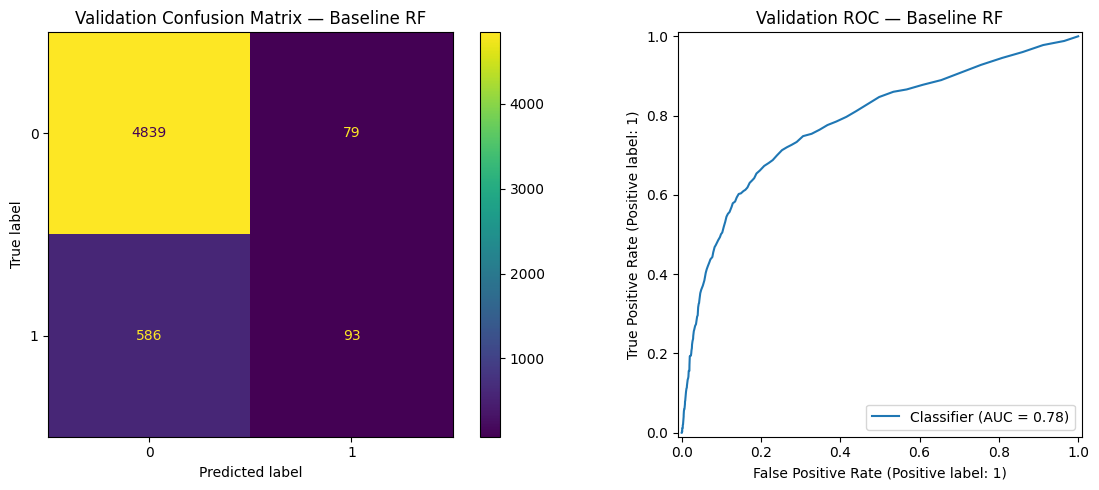

In [ ]:
# %% [code]
# %% [code] Baseline Random Forest (no tuning)
rf_baseline = Pipeline([
    ('prep', preprocess),
    ('rf', RandomForestClassifier(random_state=42, n_estimators=200, class_weight='balanced'))
])

rf_baseline.fit(X_train, y_train)

y_val_pred = rf_baseline.predict(X_val)
y_val_proba = rf_baseline.predict_proba(X_val)[:,1]

print_header("Baseline Validation Metrics")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall:", recall_score(y_val, y_val_pred))
print("F1:", f1_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_proba))
print("\nClassification report:\n", classification_report(y_val, y_val_pred))

# Create a figure with two subplots arranged side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Confusion Matrix on the first subplot
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, ax=axes[0])
axes[0].set_title("Validation Confusion Matrix — Baseline RF")

# Plot ROC Curve on the second subplot
RocCurveDisplay.from_predictions(y_val, y_val_proba, ax=axes[1])
axes[1].set_title("Validation ROC — Baseline RF")

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()
plt.show()

### Cross-validation on train+val (StratifiedKFold) — untuned

This section performs 5-fold stratified cross-validation on the combined training and validation set (`X_train_val`, `y_train_val`) using the baseline Random Forest model.


The output shows the ROC-AUC score for each of the 5 folds and the mean ROC-AUC across all folds, providing a more robust estimate of the baseline model's performance than a single train-validation split.

In [ ]:
# %% [code]
# %% [code] Cross-validation on train+val (StratifiedKFold) — untuned
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc = cross_val_score(rf_baseline, X_train_val, y_train_val, cv=skf, scoring='roc_auc', n_jobs=-1)
print_header("5-fold CV ROC-AUC on Train+Val (Baseline RF)")
print("AUC scores:", np.round(cv_auc, 4))
print("Mean AUC:", np.round(cv_auc.mean(), 4))


5-fold CV ROC-AUC on Train+Val (Baseline RF)
AUC scores: [0.7735 0.769  0.7763 0.7823 0.78  ]
Mean AUC: 0.7762


In [ ]:
# %% [code]
# %% [code] Hyperparameter tuning with RandomizedSearchCV
# We tune the RF on the combined Train+Val using inner 5-fold CV, leaving Test unseen.

rf_pipe = Pipeline([
    ('prep', preprocess),
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

param_dist = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 8, 12, 16],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2', 0.5],
}

rand_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_dist,
    n_iter=10, # Reduced the number of iterations
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rand_search.fit(X_train_val, y_train_val)
best_model = rand_search.best_estimator_
print_header("Best params (RandomizedSearchCV)")
print(rand_search.best_params_)
print("Best CV AUC:", np.round(rand_search.best_score_, 4))

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best params (RandomizedSearchCV)
{'rf__n_estimators': 300, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 4, 'rf__max_features': 'sqrt', 'rf__max_depth': 16}
Best CV AUC: 0.7884


### Hyperparameter tuning with RandomizedSearchCV

To improve the model's performance, we tune its hyperparameters using `RandomizedSearchCV`. This method samples a fixed number of hyperparameter combinations from a specified distribution, making it computationally less expensive than `GridSearchCV` when the search space is large.


The search is performed on the combined training and validation set (`X_train_val`, `y_train_val`) using inner 5-fold cross-validation. The test set remains unseen during this process.

The output shows the best hyperparameters found and the corresponding best cross-validation ROC-AUC score.

### Final evaluation on the unseen Test set

After tuning the hyperparameters on the combined train+validation set using cross-validation, the best model is evaluated one final time on the completely unseen test set (`X_test`, `y_test`).

This evaluation provides an unbiased estimate of how the model is expected to perform on new, real-world data. The same metrics (Accuracy, Precision, Recall, F1, ROC-AUC) and visualizations (Confusion Matrix, ROC Curve) used for the baseline validation are calculated and displayed for the tuned model's performance on the test set.


Unseen Test Metrics — Tuned RF
Accuracy: 0.8458395864598967
Precision: 0.40333660451422965
Recall: 0.5649484536082474
F1: 0.47065559690810194
ROC-AUC: 0.7909413538129852

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.88      0.91     10539
           1       0.40      0.56      0.47      1455

    accuracy                           0.85     11994
   macro avg       0.67      0.72      0.69     11994
weighted avg       0.87      0.85      0.86     11994



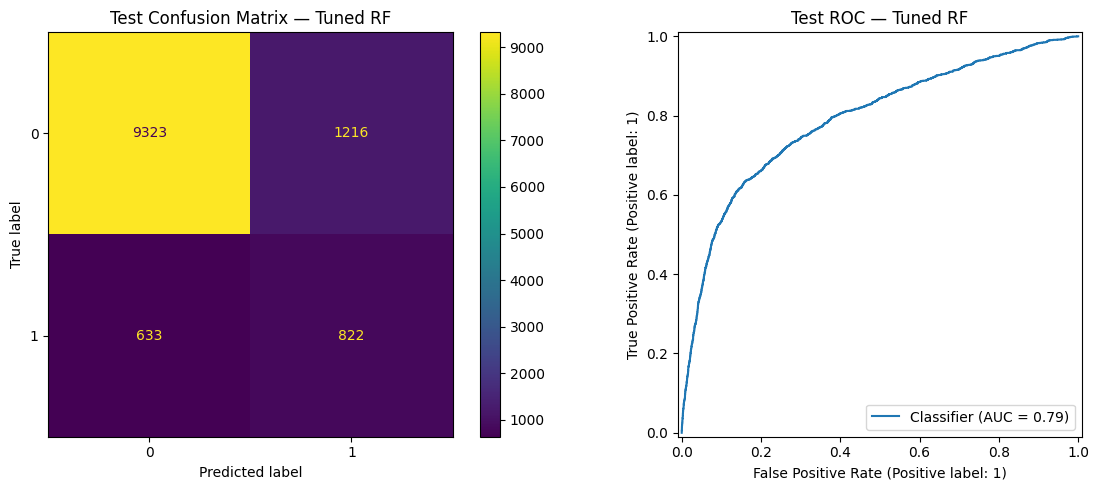

In [ ]:
# %% [code]
# %% [code] Final evaluation on the unseen Test set
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:,1]

print_header("Unseen Test Metrics — Tuned RF")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1:", f1_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print("\nClassification report:\n", classification_report(y_test, y_test_pred))

# Create a figure with two subplots arranged side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Confusion Matrix on the first subplot
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axes[0])
axes[0].set_title("Test Confusion Matrix — Tuned RF")

# Plot ROC Curve on the second subplot
RocCurveDisplay.from_predictions(y_test, y_test_proba, ax=axes[1])
axes[1].set_title("Test ROC — Tuned RF")

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()
plt.show()

### Comparison of Baseline vs. Tuned Model Performance

This section visually compares the performance metrics of the baseline Random Forest model (evaluated on the validation set) and the tuned Random Forest model (evaluated on the unseen test set).

A bar chart is generated to show the differences in Accuracy, Precision, Recall, F1-Score, and ROC-AUC between the two models. This comparison helps assess the impact of hyperparameter tuning and provides a clear summary of the final model's expected performance on new data compared to the initial baseline.

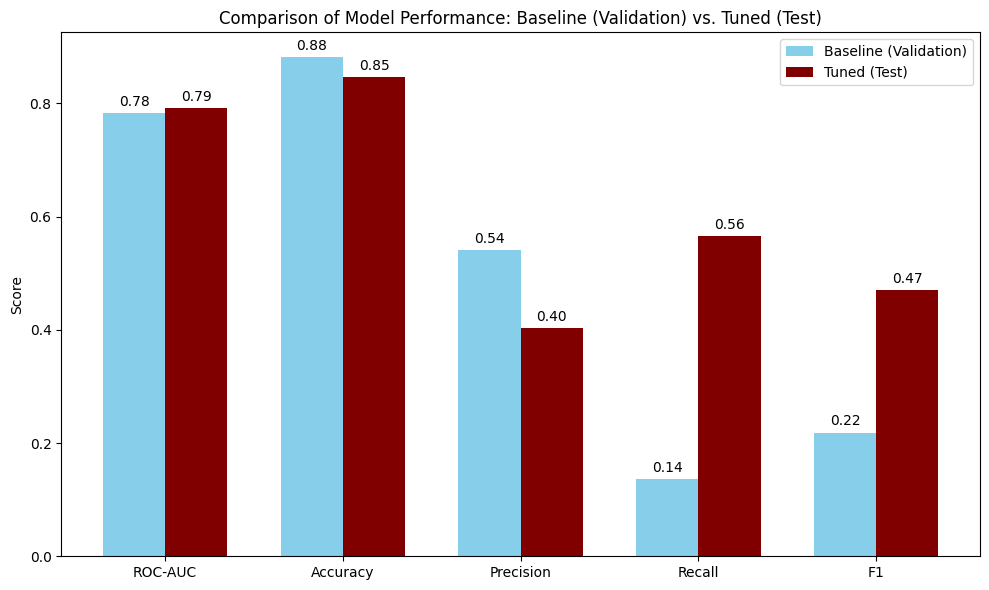

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics from baseline validation (from EGOoKPVpW1S4)
baseline_metrics = {
    'Accuracy': 0.8811863498302662,
    'Precision': 0.5406976744186046,
    'Recall': 0.13696612665684832,
    'F1': 0.21856639247943596,
    'ROC-AUC': 0.7830327533553219
}

# Metrics from tuned test (from FbAPn5bGXX32)
tuned_metrics = {
    'Accuracy': 0.8458395864598967,
    'Precision': 0.40333660451422965,
    'Recall': 0.5649484536082474,
    'F1': 0.47065559690810194,
    'ROC-AUC': 0.7909413538129852
}

labels = ['ROC-AUC','Accuracy', 'Precision', 'Recall', 'F1']
baseline_values = [baseline_metrics[metric] for metric in labels]
tuned_values = [tuned_metrics[metric] for metric in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, baseline_values, width, label='Baseline (Validation)', color='skyblue')
rects2 = ax.bar(x + width/2, tuned_values, width, label='Tuned (Test)', color='maroon')

ax.set_ylabel('Score')
ax.set_title('Comparison of Model Performance: Baseline (Validation) vs. Tuned (Test)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add some text for labels, scores, and titles.
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

### Conclusions

Based on the final evaluation on the unseen test set:

*   Hyperparameter tuning improved the model's ability to identify positive cases (subscriptions), shown by a significant increase in Recall and F1-Score compared to the baseline.
*   There was a trade-off where Precision decreased, meaning the tuned model makes more false positive predictions but captures a higher percentage of actual subscribers.
*   The ROC-AUC slightly improved, indicating a better overall ability to discriminate between the classes.

The tuned Random Forest model is a reasonable starting point for predicting bank deposit subscriptions, especially considering the imbalanced dataset.

